In [4]:
'''
统一设置地址
'''

import os

# 获取当前工作目录
current_dir = os.getcwd()
print("当前工作目录：", current_dir)

# 修改当前工作目录，以后输出文件只需要写文件名
new_dir = "D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/A_轮廓线识别/重新处理后的数据_手工筛选_0727/"
os.chdir(new_dir)
print("修改后的工作目录：", os.getcwd())

当前工作目录： D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727
修改后的工作目录： D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import os

# 读取点云数据和标签
def load_point_cloud_from_txt(file_path):
    file_path = file_path.numpy().decode("utf-8")  # 将 EagerTensor 转换为普通字符串
    data = np.loadtxt(file_path)
    points = data[:, :3]  # 获取点云坐标 (x, y, z)
    labels = data[:, 3].astype(np.int32)  # 获取类别标签
    return points, labels

# 构建数据集，加入均匀随机抽样
def create_dataset(file_paths, batch_size, num_points):
    def parse_function(file_path):
        # 加载点云数据
        points, labels = tf.py_function(
            func=load_point_cloud_from_txt, 
            inp=[file_path], 
            Tout=[tf.float32, tf.int32]
        )
        
        # 设置数据的形状
        points.set_shape([None, 3])
        labels.set_shape([None])

        # 获取点的数量
        num_total_points = tf.shape(points)[0]

        # 如果点的数量大于num_points，进行均匀随机抽样
        if num_total_points >= num_points:
            indices = tf.cast(tf.linspace(0., tf.cast(num_total_points - 1, tf.float32), num_points), tf.int32)
            points = tf.gather(points, indices)
            labels = tf.gather(labels, indices)
        else:
            # 如果点数不足，进行填充
            padding_points = tf.zeros([num_points - num_total_points, 3], dtype=tf.float32)
            points = tf.concat([points, padding_points], axis=0)
            
            padding_labels = tf.zeros([num_points - num_total_points], dtype=tf.int32)
            labels = tf.concat([labels, padding_labels], axis=0)
        
        return points, labels

    # 创建数据集
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(lambda file_path: parse_function(file_path), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)  # 保证每个批次大小一致
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # 提前加载数据以提高性能

    return dataset

# 获取文件夹中所有的点云文件
def get_all_files_in_folder(folder_path):
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".txt"):  # 假设所有点云文件都是 .txt 文件
                file_paths.append(os.path.join(root, file))
    print(f"Found {len(file_paths)} files in folder: {folder_path}")  # 添加调试信息
    return file_paths

# 划分数据集，比例为8:1:1
def split_dataset(file_paths, train_size=0.7, val_size=0.15):
    # 先按照训练集比例划分
    train_files, temp_files = train_test_split(file_paths, test_size=(1 - train_size), random_state=42)
    
    # 再从剩下的数据中划分验证集和测试集
    val_files, test_files = train_test_split(temp_files, test_size=(1 - val_size / (1 - train_size)), random_state=42)
    
    return train_files, val_files, test_files

# 保存数据集
def save_dataset(dataset, save_path):
    points_list, labels_list = [], []
    for points, labels in dataset:
        points_list.append(points.numpy())
        labels_list.append(labels.numpy())
    points_array = np.concatenate(points_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)
    np.savez(save_path, points=points_array, labels=labels_array)

# 保存文件名列表
def save_file_names(file_paths, save_path):
    with open(save_path, 'w') as f:
        for file_path in file_paths:
            f.write(file_path + '\n')

# 获取文件夹路径
data_folder = r'Oct14/新标签'  # 替换为实际的训练数据文件夹路径

# 获取文件夹中的所有文件路径
all_files = get_all_files_in_folder(data_folder)

# 划分数据集，按照8:1:1比例
train_files, val_files, test_files = split_dataset(all_files)

# 保存训练集、验证集和测试集的文件名
save_file_names(train_files, "Oct14/train_files.txt")
save_file_names(val_files, "Oct14/val_files.txt")
save_file_names(test_files, "Oct14/test_files.txt")

# 创建数据集
batch_size = 10  # 设置合适的batch size
num_points = 2048  # 设置每个点云的点数
train_dataset = create_dataset(train_files, batch_size, num_points)
val_dataset = create_dataset(val_files, batch_size, num_points)
test_dataset = create_dataset(test_files, batch_size, num_points)

# 保存数据集
save_dataset(train_dataset, "Oct14/train_dataset.npz")
save_dataset(val_dataset, "Oct14/val_dataset.npz")
save_dataset(test_dataset, "Oct14/test_dataset.npz")


Found 1100 files in folder: Oct14/新标签


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import os


# 加载保存好的数据
def load_saved_dataset(file_path, batch_size, num_points):
    # 读取 .npz 文件
    data = np.load(file_path)
    points = data['points']
    labels = data['labels']
    
    # 创建 TensorFlow 数据集
    dataset = tf.data.Dataset.from_tensor_slices((points, labels))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    # 确保批处理后的张量形状是固定的
    def set_shapes(points, labels):
        points.set_shape([batch_size, num_points, 3])
        labels.set_shape([batch_size, num_points])
        return points, labels

    dataset = dataset.map(set_shapes)
    
    return dataset

# 使用例子
batch_size = 10  # 使用保存时相同的 batch size
num_points = 2048   # 使用保存时相同的点数

train_dataset = load_saved_dataset("Oct14/train_dataset.npz", batch_size, num_points)
val_dataset = load_saved_dataset("Oct14/val_dataset.npz", batch_size, num_points)
test_dataset = load_saved_dataset("Oct14/test_dataset.npz", batch_size, num_points)

# 现在你可以使用 train_dataset 和 test_dataset 进行模型训练

In [5]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable(package="Custom")
class SamplingLayer(tf.keras.layers.Layer):
    def __init__(self, N_prime=None, **kwargs):
        super(SamplingLayer, self).__init__(**kwargs)
        self.N_prime = N_prime

    def call(self, points):
        if self.N_prime is None:
            return points, tf.range(tf.shape(points)[1])  # 不采样，直接返回原始输入点和索引
        
        B = tf.shape(points)[0]  # 获取批次大小
        N = tf.shape(points)[1]  # 获取点的数量
        C = tf.shape(points)[2]  # 获取每个点的特征维度

        sampled_points_batch = tf.TensorArray(dtype=points.dtype, size=B)
        sampled_indices_batch = tf.TensorArray(dtype=tf.int32, size=B)

        def sample_one_batch(b):
            distances = tf.ones((N,), dtype=tf.float32) * 1e10

            first_point_index = tf.random.uniform(shape=[], minval=0, maxval=N, dtype=tf.int32)
            sampled_points = tf.TensorArray(dtype=points.dtype, size=self.N_prime)
            sampled_indices = tf.TensorArray(dtype=tf.int32, size=self.N_prime)
            sampled_points = sampled_points.write(0, tf.gather(points[b], first_point_index))
            sampled_indices = sampled_indices.write(0, first_point_index)

            distances = tf.norm(points[b, :, :3] - points[b, first_point_index, :3], axis=-1)

            def body(i, sampled_points, sampled_indices, distances):
                farthest_point_index = tf.argmax(distances)
                farthest_point_index = tf.cast(farthest_point_index, tf.int32)

                farthest_point = tf.gather(points[b], farthest_point_index)
                sampled_points = sampled_points.write(i, farthest_point)
                sampled_indices = sampled_indices.write(i, farthest_point_index)
                distances = tf.minimum(distances, tf.norm(points[b, :, :3] - farthest_point[:3], axis=-1))
                return i + 1, sampled_points, sampled_indices, distances

            i = tf.constant(1)
            _, sampled_points, sampled_indices, _ = tf.while_loop(
                lambda i, *_: i < self.N_prime,
                body,
                loop_vars=[i, sampled_points, sampled_indices, distances]
            )

            return sampled_points.stack(), sampled_indices.stack()

        # 使用 tf.map_fn 处理每个批次中的点云数据
        sampled_points_batch, sampled_indices_batch = tf.map_fn(
            sample_one_batch,
            tf.range(B),
            fn_output_signature=(tf.float32, tf.int32),
            parallel_iterations=10
        )

        return sampled_points_batch, sampled_indices_batch


#调试确保sampled_points的类型和内容是对的
def call(self, sampled_points, points):
    print("sampled_points:", sampled_points)
    print("points:", points)
    sampled_points_tensor, sampled_indices = sampled_points
    # 然后继续进行其他操作

class GroupingLayer(tf.keras.layers.Layer):
    def __init__(self, R, K, **kwargs):
        super(GroupingLayer, self).__init__(**kwargs)
        self.R = R
        self.K = K

    @tf.function
    def call(self, sampled_points_tensor, sampled_indices, points):
        B = tf.shape(points)[0]      # 批次大小
        N_prime = tf.shape(sampled_points_tensor)[1]  # 采样点的数量

        # 计算采样点和所有点之间的距离
        distances = tf.norm(
            tf.expand_dims(points[:, :, :3], axis=1) - tf.expand_dims(sampled_points_tensor[:, :, :3], axis=2),
            axis=-1
        )

        # 选取距离最近的 K 个点
        _, top_k_indices = tf.nn.top_k(-distances, k=self.K)

        # 构建批次索引
        batch_indices = tf.tile(
            tf.reshape(tf.range(B), (B, 1, 1)), [1, N_prime, self.K]
        )

        # 构建正确的 gather_nd 索引，包含批次索引和点索引
        gather_indices = tf.stack([batch_indices, top_k_indices], axis=-1)

        # 使用 gather_nd 提取 K 个最接近的点
        grouped_points = tf.gather_nd(points, gather_indices)

        return grouped_points

@register_keras_serializable(package="Custom")
class PointNetLayer(tf.keras.layers.Layer):
    def __init__(self, conv_layers, **kwargs):
        super(PointNetLayer, self).__init__(**kwargs)
        self.conv_layers = conv_layers

    def call(self, local_regions):
        B, N_prime, K, D = tf.unstack(tf.shape(local_regions))
        
        # 计算局部坐标，即令每个局部区域的所有点的坐标减掉该区域的球心坐标
        center_point = local_regions[:, :, 0, :3]  # Shape: (B, N', 3)
        local_coords = local_regions[:, :, :, :3] - tf.expand_dims(center_point, axis=2)
        
        # 把局部坐标（前3个特征维度）和特征（后续特征维度）拼接到一起
        reshape_points = tf.concat([local_coords, local_regions[:, :, :, 3:]], axis=-1)
        
        # 将局部区域点云变形为 (B, N', K * D) 的形状，并转换为 float32 类型，便于进行卷积运算
        reshape_points = tf.reshape(reshape_points, (B, N_prime, K * D))
        reshape_points = tf.cast(reshape_points, dtype=tf.float32)

        new_points = reshape_points
        for layer in self.conv_layers:
            new_points = layer(new_points)
        
        new_points = tf.concat([center_point, new_points], axis=-1)
        
        return new_points

#简化SA模块
# 定义完整SA模块

    '''
    完整的Set Abstraction模块，由Sampling层、Grouping层、PointNet层串联组成。
    '''
@register_keras_serializable(package="Custom")    
class SAModule(tf.keras.layers.Layer):
    def __init__(self, sampling_layer, grouping_layer, pointnet_layer, **kwargs):
        super(SAModule, self).__init__(**kwargs)
        self.sampling_layer = sampling_layer
        self.grouping_layer = grouping_layer
        self.pointnet_layer = pointnet_layer

    def call(self, xyz, points):
        # 下采样和分组
        sampled_points_tensor, sampled_indices = self.sampling_layer(xyz)
        grouped_points = self.grouping_layer(sampled_points_tensor, sampled_indices, xyz)  # 传递采样点和原始点
        new_points = self.pointnet_layer(grouped_points)
        return sampled_points_tensor, new_points  # 返回采样后的点和提取的新特征


In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable(package="Custom")

class PointNetFeaturePropagation(tf.keras.layers.Layer):
    def __init__(self, mlp_layers, k=8, use_batchnorm=True,  **kwargs):
        super(PointNetFeaturePropagation, self).__init__(**kwargs)
        self.k = k  # 最近邻点的数量
        self.use_batchnorm = use_batchnorm
    
        self.mlp_layers = []
        
        # 根据参数添加 MLP 层，并选择是否添加 Batch Normalization 和 Dropout
        for units in mlp_layers:
            self.mlp_layers.append(layers.Conv1D(units, 1, activation=None))
            if self.use_batchnorm:
                self.mlp_layers.append(layers.BatchNormalization())
            self.mlp_layers.append(layers.ReLU())
            

    def call(self, xyz1, xyz2, points1, points2):
        """
        Inputs:
            xyz1: 上采样后的点云坐标, [B, N1, C]
            xyz2: 下采样后的点云坐标, [B, N2, C]
            points1: 上采样后的点云特征, [B, N1, D1]
            points2: 下采样后的点云特征, [B, N2, D2]
        Returns:
            new_points: 上采样后的点云特征, [B, N1, D_out]
        """
        # 最近邻插值
        interpolated_points = self.interpolate(xyz1, xyz2, points2)

        # 跳跃连接：拼接插值后的特征与上采样后的特征
        if points1 is not None:
            new_points = tf.concat([points1, interpolated_points], axis=-1)
        else:
            new_points = interpolated_points

        # 通过 MLP 处理拼接后的特征
        for layer in self.mlp_layers:
            new_points = layer(new_points)
        
        return new_points

    def interpolate(self, xyz1, xyz2, points2):
        """
        插值操作：根据 xyz1 的坐标找到 xyz2 中最近的点，并对 points2 的特征进行插值。
        """
        # 计算 xyz1 和 xyz2 之间的平方距离
        dists = square_distance(xyz1, xyz2)
        dists, idx = tf.nn.top_k(-dists, k=self.k)  # 选择 k 个最近邻
        dists = -dists

        # 避免距离为零
        dists = tf.maximum(dists, 1e-10)

        # 使用高斯函数计算权重
        sigma = 0.5  # 标准差，需要根据数据集调整
        weight = tf.exp(-dists / (2 * sigma ** 2))
        weight_sum = tf.reduce_sum(weight, axis=-1, keepdims=True)
        weight = weight / weight_sum

        # 获取对应的点的特征
        interpolated_points = index_points(points2, idx)  # [B, N1, k, D]
        
        # 使用插值权重对 points2 的特征进行加权求和
        interpolated_points = tf.reduce_sum(interpolated_points * tf.expand_dims(weight, -1), axis=2)  # [B, N1, D]
        return interpolated_points


def square_distance(src, dst):
    """
    计算点云之间的平方距离
    :param src: [B, N1, C]
    :param dst: [B, N2, C]
    :return: [B, N1, N2] 每个点与其他点的距离
    """
    diff = tf.expand_dims(src, axis=2) - tf.expand_dims(dst, axis=1)
    return tf.reduce_sum(tf.square(diff), axis=-1)

def index_points(points, idx):
    """
    根据给定的索引从 points 中提取点
    :param points: [B, N2, D2]
    :param idx: [B, N1, K]
    :return: [B, N1, K, D2]
    """
    batch_size = tf.shape(points)[0]
    batch_indices = tf.range(batch_size)[:, tf.newaxis, tf.newaxis, tf.newaxis]
    batch_indices = tf.tile(batch_indices, [1, tf.shape(idx)[1], tf.shape(idx)[2], 1])

    full_idx = tf.concat([batch_indices, idx[..., tf.newaxis]], axis=-1)
    gathered_points = tf.gather_nd(points, full_idx)
    return gathered_points


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

@register_keras_serializable(package="Custom")
class PointNetPlusPlus(tf.keras.Model):
    def __init__(self, num_classes, **kwargs):
        super(PointNetPlusPlus, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.l2_reg = 0.0001

        # SA and FP layers
        self.sa1 = SAModule(
            SamplingLayer(N_prime=1024),
            GroupingLayer(R=0.2, K=32),
            PointNetLayer(conv_layers=[
                layers.Conv1D(64, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(64, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(128, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))
            ])
        )
        self.sa2 = SAModule(
            SamplingLayer(N_prime=256),
            GroupingLayer(R=0.4, K=32),
            PointNetLayer(conv_layers=[
                layers.Conv1D(128, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(128, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(256, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))
            ])
        )
        self.sa3 = SAModule(
            SamplingLayer(N_prime=64),
            GroupingLayer(R=0.8, K=32),
            PointNetLayer(conv_layers=[
                layers.Conv1D(256, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(256, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(512, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))
            ])
        )
        self.sa4 = SAModule(
            SamplingLayer(N_prime=16),
            GroupingLayer(R=1, K=32),
            PointNetLayer(conv_layers=[
                layers.Conv1D(512, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(512, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)),
                layers.Conv1D(1024, 1, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))
            ])
        )

        # Feature Propagation layers
        self.fp4 = PointNetFeaturePropagation([512, 512])
        self.fp3 = PointNetFeaturePropagation([256, 256])
        self.fp2 = PointNetFeaturePropagation([256, 128])
        self.fp1 = PointNetFeaturePropagation([128, 128, 128])

        self.conv1 = layers.Conv1D(128, 1)
        self.bn1 = layers.BatchNormalization()
        self.drop1 = layers.Dropout(0.5)
        self.conv2 = layers.Conv1D(num_classes, 1)
        
        self.input_shape_ = None  # 初始化 input_shape_ 属性

    def call(self, inputs):
        if self.input_shape_ is None:
            self.input_shape_ = inputs.shape[1:]  # 动态获取输入的形状，排除 batch 维度

        # 提取点的3D坐标 (xyz)，假设输入数据的前三个维度是坐标
        l0_xyz = inputs[:, :, :3]  # 只保留坐标部分
        l0_points = inputs  # 所有输入点的特征

        # Set Abstraction 层
        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
        l4_xyz, l4_points = self.sa4(l3_xyz, l3_points)

        # Feature Propagation 层
        l3_points = self.fp4(l3_xyz, l4_xyz, l3_points, l4_points)  # 使用 3D 坐标
        l2_points = self.fp3(l2_xyz, l3_xyz, l2_points, l3_points)
        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp1(l0_xyz, l1_xyz, None, l1_points)

        # 最终分类
        x = tf.nn.relu(self.bn1(self.conv1(l0_points)))
        x = self.drop1(x)  # Dropout 在激活之后
        logits = self.conv2(x)
        logits = tf.nn.log_softmax(logits, axis=-1)  # 计算每个点的类别概率分布
        
        return logits
    
    def get_config(self):
        config = super(PointNetPlusPlus, self).get_config()
        config.update({
            'num_classes': self.num_classes,
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(num_classes=config['num_classes'])

In [8]:
import numpy as np
import tensorflow as tf

# 计算每个类别的 IoU

# 修改后的IoU计算函数，返回每个类别的IoU列表和平均IoU
def compute_iou(y_true, y_pred, num_classes):
    iou_list = []

    for class_id in range(num_classes):
        # 将类别标签转换为布尔掩码
        true_class = tf.equal(y_true, class_id)
        pred_class = tf.equal(y_pred, class_id)

        # 计算交集和并集
        intersection = tf.reduce_sum(tf.cast(tf.logical_and(true_class, pred_class), tf.float32))
        union = tf.reduce_sum(tf.cast(tf.logical_or(true_class, pred_class), tf.float32))

        # 防止除以零
        iou = tf.cond(tf.equal(union, 0), lambda: tf.constant(1.0), lambda: intersection / union)
        
        iou_list.append(iou)
    
    # 计算所有类别的平均 IoU
    mean_iou = tf.reduce_mean(iou_list)
    
    return iou_list, mean_iou


# 计算类别平均准确率
def compute_classwise_accuracy(true_labels, pred_labels, num_classes):
    accuracy_list = []
    
    for class_id in range(num_classes):
        true_class = (true_labels == class_id)
        pred_class = (pred_labels == class_id)
        
        correct_predictions = np.sum(np.logical_and(true_class, pred_class))
        total_class_points = np.sum(true_class)
        
        if total_class_points == 0:
            accuracy = 1.0
        else:
            accuracy = correct_predictions / total_class_points
        
        accuracy_list.append(accuracy)
    
    mean_accuracy = np.mean(accuracy_list)
    return accuracy_list, mean_accuracy
num_classes = 2  # 假设你有3个类别

# 遍历数据集，计算 IoU 和类别平均准确率
def evaluate_dataset(dataset, model, num_classes):
    all_ious = []
    all_class_accuracies = []
    
    for batch_points, batch_labels in dataset:
        # 使用模型进行预测
        pred_labels = model.predict(batch_points)
        pred_labels = np.argmax(pred_labels, axis=-1)  # 获取每个点的预测类别

        # 将 Tensor 转换为 NumPy 数组
        batch_labels = batch_labels.numpy()

        # 计算该批次的 IoU 和类别平均准确率
        iou_list, mean_iou = compute_iou(batch_labels, pred_labels, num_classes)
        accuracy_list, mean_accuracy = compute_classwise_accuracy(batch_labels, pred_labels, num_classes)

        # 保存结果
        all_ious.append(mean_iou)
        all_class_accuracies.append(mean_accuracy)
    
    # 计算所有批次的平均 IoU 和准确率
    avg_iou = np.mean(all_ious)
    avg_accuracy = np.mean(all_class_accuracies)
    
    return avg_iou, avg_accuracy


In [9]:
# 自定义回调，计算并打印每个类别的IoU
class IoUCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, num_classes):
        self.validation_data = validation_data
        self.num_classes = num_classes
        self.val_iou_history = []

    def on_epoch_end(self, epoch, logs=None):
        iou_scores_per_class = [[] for _ in range(self.num_classes)]  # 用于保存每个类别的IoU

        for batch_points, batch_labels in self.validation_data:
            # 预测类别
            pred_labels = self.model.predict(batch_points)
            pred_labels = np.argmax(pred_labels, axis=-1)
            
            # 计算每个 batch 的每个类别IoU
            batch_labels = batch_labels.numpy()
            iou_list, _ = compute_iou(batch_labels, pred_labels, self.num_classes)
            
            # 将每个类别的IoU保存起来
            for class_id in range(self.num_classes):
                iou_scores_per_class[class_id].append(iou_list[class_id].numpy())
        
        # 计算每个类别的平均IoU
        avg_iou_per_class = [np.mean(iou_scores) for iou_scores in iou_scores_per_class]
        
        # 记录每个类别的平均IoU并打印
        self.val_iou_history.append(avg_iou_per_class)
        print(f'Epoch {epoch+1}: Validation IoU per class:')
        for class_id in range(self.num_classes):
            print(f'Class {class_id} IoU: {avg_iou_per_class[class_id]:.4f}')
        
        # 计算所有类别的平均IoU（总体IoU）
        mean_iou = np.mean(avg_iou_per_class)
        print(f'Epoch {epoch+1}: Validation Mean IoU: {mean_iou:.4f}')



In [10]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Dice Loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.one_hot(y_true, depth=y_pred.shape[-1]), dtype=tf.float32)
    y_pred_f = tf.nn.softmax(y_pred)
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=[-2, -3])  # 假设形状是 (batch_size, H, W, num_classes)
    denominator = tf.reduce_sum(y_true_f + y_pred_f, axis=[-2, -3])
    
    dice = (2. * intersection + smooth) / (denominator + smooth)
    return 1 - tf.reduce_mean(dice)

# Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true_f = tf.cast(tf.one_hot(y_true, depth=y_pred.shape[-1]), dtype=tf.float32)
        y_pred_f = tf.nn.softmax(y_pred)
        
        cross_entropy = -y_true_f * tf.math.log(y_pred_f + K.epsilon())
        weight = alpha * tf.pow(1 - y_pred_f, gamma)
        
        return tf.reduce_mean(tf.reduce_sum(weight * cross_entropy, axis=-1))
    return focal_loss_fn

# Recall Loss
def recall_loss(y_true, y_pred):
    y_true_f = tf.cast(tf.one_hot(y_true, depth=y_pred.shape[-1]), dtype=tf.float32)
    y_pred_f = tf.nn.softmax(y_pred)
    
    true_positive = tf.reduce_sum(y_true_f * y_pred_f, axis=[0, 1])
    actual_positive = tf.reduce_sum(y_true_f, axis=[0, 1])
    
    recall = true_positive / (actual_positive + K.epsilon())
    return 1 - tf.reduce_mean(recall)

# 注册自定义损失函数
@tf.keras.saving.register_keras_serializable(package="Custom")
def custom_loss_with_dice_focal_recall(y_true, y_pred, num_classes):
    # Dice Loss
    dice = dice_loss(y_true, y_pred)
    
    # Focal Loss
    focal = focal_loss(gamma=2.0, alpha=0.25)(y_true, y_pred)
    
    # Recall Loss
    recall = recall_loss(y_true, y_pred)

    # 组合三个损失
    total_loss = dice + focal + recall
    return total_loss

# 注册包装函数，将 Keras 的损失函数与类别数绑定
@tf.keras.saving.register_keras_serializable(package="Custom")
def loss_fn(y_true, y_pred):
    num_classes = 2  # 设置类别数量
    return custom_loss_with_dice_focal_recall(y_true, y_pred, num_classes)




Model: "point_net_plus_plus_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sa_module_4 (SAModule)      multiple                  18688     
                                                                 
 sa_module_5 (SAModule)      multiple                  61952     
                                                                 
 sa_module_6 (SAModule)      multiple                  222208    
                                                                 
 sa_module_7 (SAModule)      multiple                  837632    
                                                                 
 point_net_feature_propagat  multiple                  1056768   
 ion_4 (PointNetFeatureProp                                      
 agation)                                                        
                                                                 
 point_net_feature_propagat  multiple        

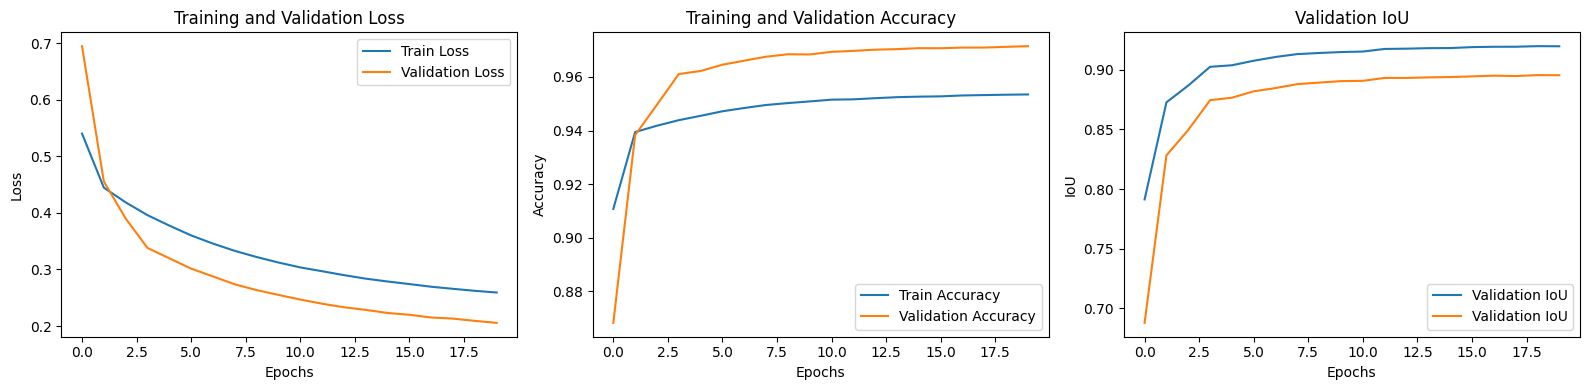

In [13]:

# 定义模型
num_classes = 2
model = PointNetPlusPlus(num_classes=num_classes)

# 编译模型，设置学习率
initial_learning_rate = 0.0005
decay_rate = -0.1  
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)


# 编译模型
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss=loss_fn,
    metrics=['accuracy']  # 你可以根据需求添加其他评估指标
)

model.build(input_shape=(None, 2048, 3))
model.summary()
# 定义学习率调度函数
def scheduler(epoch, lr):
    if epoch < 2:
        return float(lr)
    else:
        return float(lr * tf.math.exp(decay_rate).numpy())

# 定义学习率调度回调和早停回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)


# 定义早停回调，监控验证集准确率
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',   # 监控验证集准确率
    patience=3,   # 如果验证集准确率 10 个 epoch 没有提升，停止训练
    restore_best_weights=True   # 恢复训练过程中表现最好的模型权重
)

# 定义 IoU 回调
iou_callback = IoUCallback(validation_data=test_dataset, num_classes=2)  # 假设有3个类别

# 开始训练模型并获取训练过程中的历史数据
history = model.fit(
    train_dataset, 
    epochs=20,
    validation_data=val_dataset,
    callbacks=[ lr_scheduler, early_stopping_callback, iou_callback]
)

# 保存模型
model.save('Oct14/pointnet2_segmentation_model_1.keras')

# 在测试集上评估模型
loss, accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# 绘制训练和验证损失、准确率和 IoU 曲线
plt.figure(figsize=(16, 4))

# 绘制损失曲线
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# 绘制 IoU 曲线
plt.subplot(1, 3, 3)
plt.plot(iou_callback.val_iou_history, label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Validation IoU')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
model_load_path = r'Oct14/pointnet2_segmentation_model_1.keras'

# 自定义损失函数字典
custom_objects = {
    'PointNetPlusPlus': PointNetPlusPlus,  # 确保包含你的模型类
    'custom_loss_with_dice_focal_recall': custom_loss_with_dice_focal_recall,  # 添加新的自定义损失函数
    'loss_fn': loss_fn  # 你也可以将包装的损失函数添加进去
}

try:
    model = tf.keras.models.load_model(model_load_path, custom_objects=custom_objects, safe_mode=False)
    print("模型加载成功！")
except Exception as e:
    print("模型加载失败:", e)

模型加载成功！


Unique labels in test set: [0 1]
Test labels shape: (160, 2048)
Test labels min: 0 Test labels max: 1
5/5 [==============================] - 6s 978ms/step
Test labels shape: (160, 2048)
Predicted classes shape: (160, 2048)
Precision: 0.9480
Recall: 0.9553
F1 Score: 0.9501
Class 1: FN Probability = 0.0445, FP Probability = 0.0049
Class 2: FN Probability = 0.0049, FP Probability = 0.0445


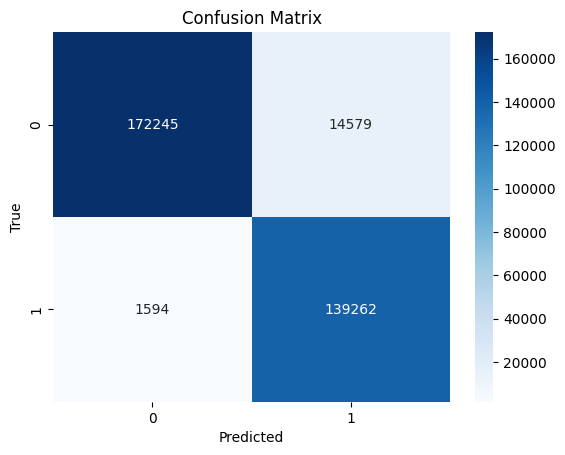

In [15]:
'''
混淆矩阵 测试集
'''
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 加载测试集数据
def load_npz_dataset(npz_file):
    data = np.load(npz_file)
    points = data['points']  # shape: [num_samples, num_points, 3]
    labels = data['labels']  # shape: [num_samples, num_points]
    
    # 检查标签的唯一值和范围
    print("Unique labels in test set:", np.unique(labels))
    print("Test labels shape:", labels.shape)
    print("Test labels min:", np.min(labels), "Test labels max:", np.max(labels))
    
    return points, labels

# 加载测试集
test_points, test_labels = load_npz_dataset("Oct14/test_dataset.npz")

# 2. 加载训练好的模型
# model = tf.keras.models.load_model('Sept7/pointnet2_segmentation_model.keras')  # 请替换为你实际保存模型的路径

# 3. 使用模型进行预测
y_pred = model.predict(test_points)  # y_pred shape: [num_samples, num_points, num_classes]

# 如果模型输出的是概率分布，需要将其转换为类别索引
y_pred_classes = np.argmax(y_pred, axis=-1)  # shape: [num_samples, num_points]

# 5. 展平标签和预测结果前，检查形状是否一致
print("Test labels shape:", test_labels.shape)  # Expected: [num_samples, num_points]
print("Predicted classes shape:", y_pred_classes.shape)  # Expected: [num_samples, num_points]

# 6. 展平标签和预测结果
y_test = test_labels.flatten()  # shape: [num_samples * num_points]
y_pred_classes_flat = y_pred_classes.flatten()  # shape: [num_samples * num_points]

# 7. 检查展平后的形状是否一致
assert y_test.shape == y_pred_classes_flat.shape, "Shape mismatch between true labels and predictions!"

# 8. 生成混淆矩阵并可视化
# 在混淆矩阵中，明确指定标签为 [1, 2] 而不是从 0 开始
cm = confusion_matrix(y_test, y_pred_classes_flat, labels=[0, 1])

# 使用 seaborn 绘制混淆矩阵的热力图
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])

# 9. 计算精确率、召回率和F1分数
precision = precision_score(y_test, y_pred_classes_flat, average='macro')
recall = recall_score(y_test, y_pred_classes_flat, average='macro')
f1 = f1_score(y_test, y_pred_classes_flat, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 初始化 TN 和 FP 的概率数组
num_classes = cm.shape[0]
FN_prob = np.zeros(num_classes)
FP_prob = np.zeros(num_classes)

# 计算每个类别的真阴性和假阳性概率
total_samples = np.sum(cm)  # 总样本数

for i in range(num_classes):
    # 计算 TP、FN 和 FP
    TP = cm[i, i]  # 类别 i 的真阳性
    FN = np.sum(cm[i, :]) - TP  # 假阴性：类别 i 的总数 - 真阳性
    FP = np.sum(cm[:, i]) - TP  # 假阳性：类别 i 的预测总数 - 真阳性
    
    # 计算 FN 和 FP 的概率
    FN_prob[i] = FN / total_samples  # 假阴性概率
    FP_prob[i] = FP / total_samples  # 假阳性概率

# 输出每个类别的 FN 和 FP 概率
for i in range(num_classes):
    print(f"Class {i+1}: FN Probability = {FN_prob[i]:.4f}, FP Probability = {FP_prob[i]:.4f}")



plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


使用了 1 轮插值来让点云点数满足要求
1/1 [==============================] - 0s 145ms/step
Vertices shape: (9630, 3)
Sampled indices shape: (2048,)
Sampled indices: [  68 2271 4481 ... 8463 2828 2783]
Sampled predictions shape after squeezing: (2048, 2)
类别 0: 4658 次，占 48.37%
类别 1: 4972 次，占 51.63%
最大类别为: 1


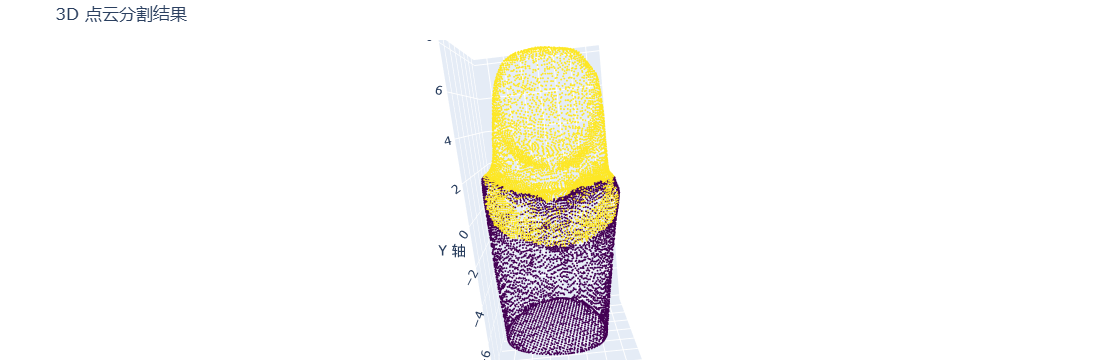

In [16]:
'''
OPEN 3D 预测结果初步可视化
'''
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import plotly.graph_objects as go
import open3d as o3d
import chardet

file_path= r'D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727\50颗_1012\151.obj'
#file_path = r'D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727\肩台外侧点_0715\150颗\121.obj' # 替换为实际的 OBJ 文件路径
#file_path = r'D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727\肩台外侧点_0715\123\123_9.obj'
#file_path = r'D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727\肩台外侧点_0715\4\4_1.obj'
#file_path = r'D:/150_0913/0812-1-5_4.obj' 
#file_path = r'D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727\ShoulderOutsidePoints_0815\0812-1-5_4.obj'
#file_path = r'D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727\肩台外侧点_0715\牙根\4_缩小.obj'
#file_path = r'D:\BaiduSyncdisk\新建文件夹\桌面文件\机器评分\三维模型\obj-80颗\obj\DATA-obj版\13-LYN-4.obj' #非同颗原始牙
#file_path= r'D:\BaiduSyncdisk\新建文件夹\桌面文件\机器评分\三维模型\后牙\1.obj' #后牙

def detect_encoding(file_path):
    '''检测文件的encoding方式'''
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        return result['encoding']
        
def load_obj_file(file_path, encoding):
    '''读取obj文件中的点云坐标，输出是list'''
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding=encoding) as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")
    return vertices, faces

def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

def insert_midpoint_points(vertices, faces, minimum_vertices_number=3000):
    if len(vertices) >= minimum_vertices_number:
        print('原始点云的点数足够多')
        return vertices, faces

    else:
        temp = 0
        while len(vertices) < minimum_vertices_number:
            edge_to_midpoint = {}
            new_points = []
            new_faces = []
            vertex_offset = len(vertices)
    
            for face in faces:
                # Compute midpoints for each edge
                midpoints = []
                for i in range(len(face)):
                    edge = tuple(sorted((face[i], face[(i + 1) % len(face)])))
                    if edge not in edge_to_midpoint:
                        midpoint = np.mean([vertices[edge[0]], vertices[edge[1]]], axis=0)
                        edge_to_midpoint[edge] = vertex_offset + len(new_points)
                        new_points.append(midpoint.tolist())
                    midpoints.append(edge_to_midpoint[edge])
                
                # Original vertices
                v0, v1, v2 = face
                # Midpoints
                m0, m1, m2 = midpoints

                # Create four new faces
                new_faces.append([v0, m0, m2])
                new_faces.append([v1, m1, m0])
                new_faces.append([v2, m2, m1])
                new_faces.append([m0, m1, m2])
    
            vertices = np.concatenate([vertices, np.array(new_points)], axis=0)
            faces = new_faces
            temp += 1

        print(f'使用了 {temp} 轮插值来让点云点数满足要求')
        
    return vertices, faces

    def get_or_create_midpoint(v1, v2):
        edge = tuple(sorted((v1, v2)))
        if edge not in edge_to_midpoint:
            midpoint = (vertices[v1] + vertices[v2]) / 2
            edge_to_midpoint[edge] = len(new_vertices)
            new_vertices.append(midpoint)
        return edge_to_midpoint[edge]

    def process_face(face):
        return [get_or_create_midpoint(int(face[i]), int(face[(i + 1) % len(face)])) for i in range(len(face))]

    new_faces = [process_face(face) for face in faces]

    return np.array(new_vertices), new_faces

def furthest_point_sampling(points, num_samples):
    """
    从给定的点中选择最远点采样。
    :param points: 输入的点集合，形状为 (N, D)，N为点的数量，D为维度（2或3）。
    :param num_samples: 需要采样的点数量。
    :return: 选中的最远点索引的集合和坐标的集合。
    """
    N, D = points.shape
    # 初始化已选择的点集合
    sampled_indices = np.zeros(num_samples, dtype=int)
    
    # 随机选择第一个点
    sampled_indices[0] = np.random.randint(0, N)
    
    # 计算第一个样本到所有点的距离
    distances = np.linalg.norm(points - points[sampled_indices[0]], axis=1)

    for i in range(1, num_samples):
        # 选择距离已选点集中最远的点
        sampled_indices[i] = np.argmax(distances)
        
        # 更新距离
        new_distances = np.linalg.norm(points - points[sampled_indices[i]], axis=1)
        distances = np.minimum(distances, new_distances)

    return sampled_indices, points[sampled_indices]

def process_point_cloud(file_path, num_samples):
    # 加载点云数据，确保 load_point_cloud_from_obj 返回正确的 vertices 和 faces
    obj_encoding = detect_encoding(file_path)
    obj_vertices, obj_faces = load_obj_file(file_path, obj_encoding)
    vertices = center_vertices(obj_vertices)

    # 判断是否需要插值
    if len(vertices) < 3000:
        vertices, faces = insert_midpoint_points(vertices, obj_faces, minimum_vertices_number=3000)

    # 进行随机抽样
    
    sampled_vertices = random_point_sampling(vertices, num_samples)

    return sampled_vertices, obj_faces

#特征传输
def feature_upsampling(vertices, sampled_indices, sampled_predictions, K=5):
    # 确保 vertices 是 numpy 数组
    vertices = np.array(vertices)
    # 确保 sampled_indices 是整数数组
    sampled_indices = np.array(sampled_indices, dtype=int)
    # 去除批次维度
    sampled_predictions = np.squeeze(sampled_predictions, axis=0)

    # 调试信息
    print("Vertices shape:", vertices.shape)
    print("Sampled indices shape:", sampled_indices.shape)
    print("Sampled indices:", sampled_indices)
    print("Sampled predictions shape after squeezing:", sampled_predictions.shape)
    
    dic = {i: value for i, value in enumerate(sampled_indices)}
    try:
        temp_points = vertices[sampled_indices]
    except Exception as e:
        print("Error when indexing vertices with sampled_indices:", e)
        return None  # 可以根据需要选择适当的处理方式

    up_predictions = []
    for i in range(len(vertices)):
        if i in sampled_indices:
            # 找到采样点在 sampled_indices 中的位置并获取相应的预测值
            index = np.where(sampled_indices == i)[0][0]
            up_predictions.append(sampled_predictions[index])
        else:
            P = vertices[i]
            distances = np.linalg.norm(temp_points - P, axis=1)
            idx = np.argsort(distances)[:K]
            dis = np.array(distances[idx])
            weights = 1.0 / dis
            temp_predictions = np.array(sampled_predictions[idx])
            temp_prob = np.dot(weights, temp_predictions)/np.sum(weights)
            up_predictions.append(temp_prob)
    return up_predictions

# 获取点云数据

obj_encoding = detect_encoding(file_path)
obj_vertices, obj_faces = load_obj_file(file_path, obj_encoding)
vertices = center_vertices(obj_vertices)

#加密插值点， 生成新的面
checked_vertices, faces = insert_midpoint_points(vertices, obj_faces, 3000)  # 对点数小于5000的点云做插值加密

#下采样至模型可以预测的点数
sampled_indices, sampled_vertices = furthest_point_sampling(np.array(checked_vertices), num_samples=2048)

sampled_indices = np.array(sampled_indices, dtype=int)

# 使用模型进行预测
point_cloud_data = np.expand_dims(sampled_vertices, axis=0)  # 添加批次维度


# 进行预测，获得 logits（未应用 softmax 的原始输出）
predictions = model.predict(point_cloud_data)


# 对 predictions 应用 softmax，转换为概率
probabilities = tf.nn.softmax(predictions, axis=-1).numpy()


# 特征传输
up_probabilities = feature_upsampling(checked_vertices, sampled_indices, probabilities, K=5)


# 获取每个点的预测类别
predicted_labels = np.argmax(up_probabilities, axis=-1).squeeze()


# 统计每个类别出现的次数
unique, counts = np.unique(predicted_labels, return_counts=True)

# 计算每个类别的百分比
total_points = len(predicted_labels)
percentages = (counts / total_points) * 100

# 打印类别和对应的百分比
for label, count, percentage in zip(unique, counts, percentages):
    print(f"类别 {label}: {count} 次，占 {percentage:.2f}%")

# 确保颜色映射是合理的
if np.max(predicted_labels) == 0:
    print("警告：所有预测的类别都为 0，可能存在问题")
else:
    print("最大类别为:", np.max(predicted_labels))

# 确保 checked_vertices 是 numpy 数组
checked_vertices = np.array(checked_vertices)

# 创建颜色映射
colors = predicted_labels / np.max(predicted_labels)  # 确保类别与颜色正确映射

# 使用 plotly 进行 3D 可视化
fig = go.Figure(data=[go.Scatter3d(
    x=checked_vertices[:, 0],  # 修正为正确的点云数据
    y=checked_vertices[:, 1],
    z=checked_vertices[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=colors,  # 将类别映射到颜色
        colorscale='Viridis',
        opacity=1
    )
)])

fig.update_layout(
    scene=dict(
        xaxis=dict(title='X 轴'),
        yaxis=dict(title='Y 轴'),
        zaxis=dict(title='Z 轴'),
    ),
    title='3D 点云分割结果',
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()



使用了 1 轮插值来让点云点数满足要求
1/1 [==============================] - 0s 143ms/step
Predicted labels: [1 0 0 ... 0 0 1]
类别 0: 1172 次，占 57.23%
类别 1: 876 次，占 42.77%
Label distribution: Counter({1: 5126, 0: 4504})
voting_labels shape: (9630,)
尝试容差 0.10
尝试容差 0.12
尝试容差 0.14
尝试容差 0.16
尝试容差 0.18
尝试容差 0.20
标签种类及其百分比:
标签 0: 4425 (百分比: 45.95%)
标签 1: 5205 (百分比: 54.05%)


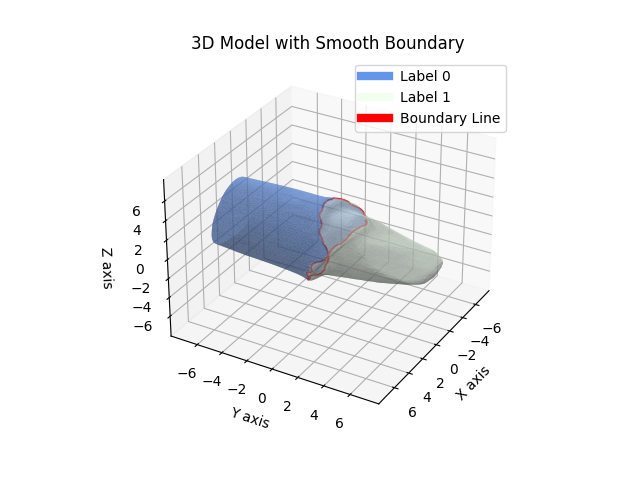

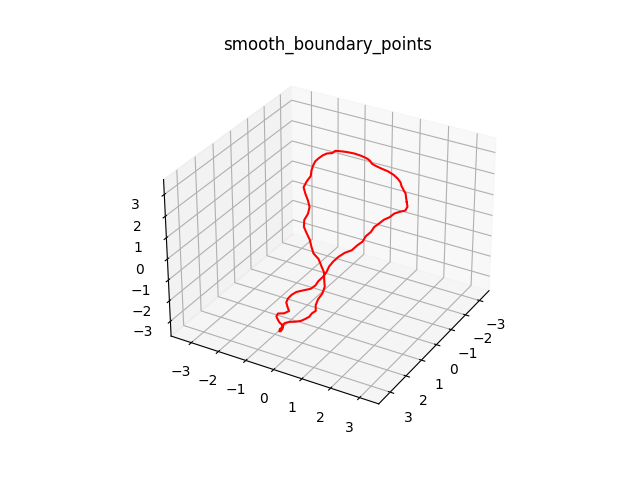

In [15]:
'''
平滑边界的三角网格
'''
import numpy as np
import open3d as o3d
import networkx as nx
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from sklearn.neighbors import NearestNeighbors
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline
from scipy.spatial import distance_matrix
from scipy.ndimage import gaussian_filter1d
from sklearn.neighbors import KDTree
from collections import Counter
import chardet

def detect_encoding(file_path):
    '''检测文件的encoding方式'''
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        return result['encoding']
        
def load_obj_file(file_path, encoding):
    '''读取obj文件中的点云坐标，输出是list'''
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding=encoding) as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")
    return vertices, faces

def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

def insert_midpoint_points(vertices, faces, minimum_vertices_number=3000):
    if len(vertices) >= minimum_vertices_number:
        print('原始点云的点数足够多')
        return vertices, faces

    else:
        temp = 0
        while len(vertices) < minimum_vertices_number:
            edge_to_midpoint = {}
            new_points = []
            new_faces = []
            vertex_offset = len(vertices)
    
            for face in faces:
                # Compute midpoints for each edge
                midpoints = []
                for i in range(len(face)):
                    edge = tuple(sorted((face[i], face[(i + 1) % len(face)])))
                    if edge not in edge_to_midpoint:
                        midpoint = np.mean([vertices[edge[0]], vertices[edge[1]]], axis=0)
                        edge_to_midpoint[edge] = vertex_offset + len(new_points)
                        new_points.append(midpoint.tolist())
                    midpoints.append(edge_to_midpoint[edge])
                
                # Original vertices
                v0, v1, v2 = face
                # Midpoints
                m0, m1, m2 = midpoints

                # Create four new faces
                new_faces.append([v0, m0, m2])
                new_faces.append([v1, m1, m0])
                new_faces.append([v2, m2, m1])
                new_faces.append([m0, m1, m2])
    
            vertices = np.concatenate([vertices, np.array(new_points)], axis=0)
            faces = new_faces
            temp += 1

        print(f'使用了 {temp} 轮插值来让点云点数满足要求')
        
    return vertices, faces

    def get_or_create_midpoint(v1, v2):
        edge = tuple(sorted((v1, v2)))
        if edge not in edge_to_midpoint:
            midpoint = (vertices[v1] + vertices[v2]) / 2
            edge_to_midpoint[edge] = len(new_vertices)
            new_vertices.append(midpoint)
        return edge_to_midpoint[edge]

    def process_face(face):
        return [get_or_create_midpoint(int(face[i]), int(face[(i + 1) % len(face)])) for i in range(len(face))]

    new_faces = [process_face(face) for face in faces]

    return np.array(new_vertices), new_faces

def furthest_point_sampling(points, num_samples):
    """
    从给定的点中选择最远点采样。
    :param points: 输入的点集合，形状为 (N, D)，N为点的数量，D为维度（2或3）。
    :param num_samples: 需要采样的点数量。
    :return: 选中的最远点索引的集合和坐标的集合。
    """
    N, D = points.shape
    # 初始化已选择的点集合
    sampled_indices = np.zeros(num_samples, dtype=int)
    
    # 随机选择第一个点
    sampled_indices[0] = np.random.randint(0, N)
    
    # 计算第一个样本到所有点的距离
    distances = np.linalg.norm(points - points[sampled_indices[0]], axis=1)

    for i in range(1, num_samples):
        # 选择距离已选点集中最远的点
        sampled_indices[i] = np.argmax(distances)
        
        # 更新距离
        new_distances = np.linalg.norm(points - points[sampled_indices[i]], axis=1)
        distances = np.minimum(distances, new_distances)

    return sampled_indices, points[sampled_indices]

def calculate_parts(predicated_labels, sampled_indices):
    '''生成原始点云中各组件的索引名单，这个函数我没有做测试'''
    parts = []
    for i in range(2):
        temp = np.where(predicted_labels == i)[0].tolist() 
        parts.append(sampled_indices[temp])
    return parts
    
def perform_up_voting(vertices, parts):
    """
    为点云数据中的每个点分配标签，确保每个 part 的标签与其索引一致，同时使用投票机制对未标记的点进行标签分配。
    
    参数:
    vertices: 点云数据，形状为 (n, 3)，每行表示一个点的 (x, y, z) 坐标。
    parts: 列表，包含每个分区的点的索引列表。
    
    返回:
    labels: 点的标签，形状为 (n,)，每个标签是一个整数。
    """
    # 创建 KDTree 以高效地查找邻域
    tree = KDTree(vertices)
    
    # 创建标签数组
    labels = np.full(len(vertices), -1, dtype=int)  # 使用 -1 表示未标记的点
    
    # 为每个 part 分配标签，标签从 0 开始
    for i, part in enumerate(parts):
        for idx in part:
            labels[idx] = i  # 直接使用 i，标签从 0 开始
    
    # 临时标签数组用于存储投票结果
    temp_labels = np.full(len(vertices), -1, dtype=int)  # 使用 -1 作为初始值
    
    # 设置邻域半径的初始值和最大值
    r_min = 0.2
    r_max = 1
    r_increment = 0.2
    
    # 对每个未标记的点进行投票
    for i, vertex in enumerate(vertices):
        if labels[i] >= 0:  # 修改为 >= 0，跳过已经标记的点
            continue  # 跳过已经标记的点
        
        # 初始化邻域半径
        r = r_min
        found_valid_neighbor = False
        
        while r <= r_max:
            # 查找邻居
            neighbors, distances = tree.query_radius([vertex], r=r, return_distance=True)
            neighbors = neighbors[0]  # 提取索引数组
            distances = distances[0]  # 提取距离数组
            
            # 只考虑已标记的邻居进行投票
            valid_neighbors = neighbors[labels[neighbors] >= 0]  # 修改为 >= 0
            valid_distances = distances[labels[neighbors] >= 0]
            
            if len(valid_neighbors) > 2:  # 确保有足够的有效邻居
                found_valid_neighbor = True
                break
            r += r_increment
        
        if not found_valid_neighbor:
            continue

        # 如果找到有效邻居，进行标签投票
        neighbor_labels = labels[valid_neighbors]
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        
        if len(unique_labels) > 0:
            # 获取最高计数的标签
            max_count = np.max(counts)
            candidates = unique_labels[counts == max_count]
            
            if len(candidates) > 1:  # 如果有多个标签计数相同，选择平均距离最小的标签
                avg_distances = np.array([np.mean(valid_distances[neighbor_labels == label]) for label in candidates])
                best_label = candidates[np.argmin(avg_distances)]
            else:
                best_label = candidates[0]
            
            temp_labels[i] = best_label
    
    # 更新最终标签
    labels[temp_labels >= 0] = temp_labels[temp_labels >= 0]  # 使用 >= 0 来更新投票分配的标签
    
    return labels


# 获取最大连通子图
def largest_connected_component(G, nodes):
    subgraph = G.subgraph(nodes)
    largest_cc = max(nx.connected_components(subgraph), key=len)
    return subgraph.subgraph(largest_cc)

'''找到各标签的最大连通子图'''
def get_max_connected_subgraphs(G, labels, target_labels):
    subgraphs = {}
    for label in target_labels:
        nodes = [i for i, l in enumerate(labels) if l == label]
        if nodes:
            largest_cc = largest_connected_component(G, nodes)
            subgraphs[label] = largest_cc
    return subgraphs

'''找到某两个标签之间的边界线'''
def find_boundary_edges(G, subgraph1, subgraph2):
    boundary_edges = []
    for edge in G.edges():
        if (edge[0] in subgraph1 and edge[1] in subgraph2) or (edge[0] in subgraph2 and edge[1] in subgraph1):
            boundary_edges.append(edge)
    return boundary_edges

# 构建拓扑图
def generate_graph(vertices, faces):
    """
    生成点云的拓扑图。
    """
    G = nx.Graph()
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)
    for face in faces:
        for i in range(len(face)):
            G.add_edge(face[i], face[(i + 1) % len(face)])
    return G



# 局部加权平滑函数
def local_weighted_smooth(x, y, z, window_size=5, sigma=1.0):
    def smooth1d(data, window_size, sigma):
        smoothed = np.copy(data)
        for i in range(len(data)):
            start = max(0, i - window_size // 2)
            end = min(len(data), i + window_size // 2 + 1)
            weights = np.exp(-0.5 * ((np.arange(start, end) - i) ** 2) / sigma ** 2)
            weights /= weights.sum()
            smoothed[i] = np.dot(weights, data[start:end])
        return smoothed

    x_smoothed = smooth1d(x, window_size, sigma)
    y_smoothed = smooth1d(y, window_size, sigma)
    z_smoothed = smooth1d(z, window_size, sigma)
    
    
    return x_smoothed, y_smoothed, z_smoothed


# 计算边的中点
def compute_edge_midpoints(vertices, boundary_edges):
    vertices = np.array(vertices)  # 确保顶点是 numpy 数组
    midpoints = []
    for edge in boundary_edges:
        midpoint = (vertices[edge[0]] + vertices[edge[1]]) / 2
        midpoints.append(midpoint)
    return np.array(midpoints)


# 计算点云的质心
def calculate_centroid(points):
    return np.mean(points, axis=0)

# 计算点在XOZ平面的投影并排序
def sort_midpoints_by_angle(midpoints, centroid):
    # 将中点投影到XOZ平面
    midpoints_xoz = midpoints[:, [0, 2]]

    # 计算每个点相对于质心的向量
    vectors = midpoints_xoz - centroid[[0, 2]]

    # 计算每个向量与X轴正方向的夹角
    angles = np.arctan2(vectors[:, 1], vectors[:, 0])

    # 按照角度进行排序
    sorted_indices = np.argsort(angles)
    sorted_midpoints = midpoints[sorted_indices]

    # 闭合曲线
    sorted_midpoints = np.vstack([sorted_midpoints, sorted_midpoints[0]])

    return sorted_midpoints

# 打印排序后的中点并检查
def print_sorted_midpoints(midpoints):
    print("排序后的中点坐标：")
    for idx, point in enumerate(midpoints):
        print(f"点 {idx}: {point}")


# 拟合平滑曲线
def fit_smooth_curve(points, file_path, output_dir, num_points=100, smooth_factor1=1.0, window_size=5, smooth_factor2=2):
    if len(points) < 2:
        return points
    
    x_new = points[:, 0]
    y_new = points[:, 1]
    z_new = points[:, 2]
    
    # Apply local weighted smoothing
    x_smoothed, y_smoothed, z_smoothed = local_weighted_smooth(x_new, y_new, z_new, window_size, smooth_factor1)
    
    # Apply Gaussian filter to smooth the curve
    x_smoothed = gaussian_filter1d(x_smoothed, sigma=smooth_factor2)
    y_smoothed = gaussian_filter1d(y_smoothed, sigma=smooth_factor2)
    z_smoothed = gaussian_filter1d(z_smoothed, sigma=smooth_factor2)
    
    # Wrap the curve (optional, depending on the desired effect)
    x_smoothed = np.concatenate([x_smoothed, [x_smoothed[0]]])
    y_smoothed = np.concatenate([y_smoothed, [y_smoothed[0]]])
    z_smoothed = np.concatenate([z_smoothed, [z_smoothed[0]]])
    
    # Perform spline interpolation
    tck, u = splprep([x_smoothed, y_smoothed, z_smoothed], s=0)
    
    # 从file_path中获取文件名，并构造输出文件路径
    obj_filename = os.path.splitext(os.path.basename(file_path))[0]  # 获取去掉扩展名的文件名
    output_file = os.path.join(output_dir, obj_filename + '_tck.txt')  # 构造输出文件路径
    
    # Save the spline equation to a file
    with open(output_file, 'w') as f:
        f.write("Spline equation:\n")
        f.write(f"Spline order: {tck[2]}\n")
        f.write("Knots:\n")
        f.write(" ".join(map(str, tck[0])) + "\n")
        f.write("Coefficients (x, y, z):\n")
        for coeff in tck[1]:
            f.write(" ".join(map(str, coeff)) + "\n")
    
    # Generate the smooth curve points using the spline
    new_points = np.vstack(splev(np.linspace(0, 1, num_points), tck)).T
    
    return new_points


def is_on_curve(vertex, curve_points, tolerance):
    for point in curve_points:
        if np.linalg.norm(vertex - point) < tolerance:
            return True
    return False


def segment_point_cloud(vertices, faces, interpolated_marks):
    tolerance = 0.1
    max_tolerance = 1.00
    tolerance_increment = 0.02
    flag_segmentation = 1

    while tolerance <= max_tolerance:
        print(f'尝试容差 {tolerance:.2f}')
        G = generate_graph(vertices, faces)
        curve_points = np.array(interpolated_marks)
        
        # 找到封闭曲线上的顶点
        curve_points_indices = set()
        for i, vertex in enumerate(vertices):
            if is_on_curve(np.array(vertex), curve_points, tolerance):
                curve_points_indices.add(i)
        
        # 从图中删除封闭曲线上的点
        G.remove_nodes_from(curve_points_indices)
        
        # 使用图的连通性找到两个区域
        components = list(nx.connected_components(G))
        part1 = set()
        part2 = set()
        
        if len(components) > 1:
            part1 = components[0]
            part2 = components[1]
            if len(part1)>50 and len(part2)>50:  # 排除坑底小孤岛
                return part1, part2, curve_points_indices, flag_segmentation
            else:
                tolerance += tolerance_increment
        else:
            tolerance += tolerance_increment

    flag_segmentation = 0
    print("分割失败：无法找到两个独立的组件")
    return set(), set(), set(), flag_segmentation

def perform_on_voting(vertices, part1, part2):
    # 将 part1 和 part2 从 set 转换为 numpy 数组
    part1 = np.array(list(part1))
    part2 = np.array(list(part2))
    
    # 创建 KDTree 以高效地查找邻域
    vertices_array = np.array(vertices)
    tree = KDTree(vertices_array)
    
    # 创建标签数组
    labels = np.zeros(len(vertices), dtype=int)
    labels[part1] = 0
    labels[part2] = 1
    
    # 创建一个临时标签数组用于存储投票结果
    temp_labels = np.full(len(vertices), -1, dtype=int)  # 使用 -1 初始化未标记的标签
    
    # 设置邻域半径的初始值和最大值
    r_min = 0.2
    r_max = 1
    r_increment = 0.2
    
    # 对每个点进行投票
    for i, vertex in enumerate(vertices):
        if i in part1 or i in part2:
            continue  # 跳过已经标记的点
        
        # 初始化邻域半径
        r = r_min
        found_valid_neighbor = False
        
        while r <= r_max:
            # 查找邻居
            neighbors = tree.query_radius([vertex], r=r)[0]
            
            # 检查 part1 和 part2 是否为空，然后拼接
            if part1.size > 0 and part2.size > 0:
                valid_neighbors = neighbors[np.isin(neighbors, np.concatenate([part1, part2]))]
            elif part1.size > 0:
                valid_neighbors = neighbors[np.isin(neighbors, part1)]
            elif part2.size > 0:
                valid_neighbors = neighbors[np.isin(neighbors, part2)]
            else:
                valid_neighbors = []  # 没有有效邻居，继续增大半径
            
            if len(valid_neighbors) > 2:
                found_valid_neighbor = True
                break
            r += r_increment
        
        if not found_valid_neighbor:
            # 如果没有找到有效邻居，跳过该点
            continue
        
        # 如果找到有效邻居，进行标签投票
        neighbor_labels = labels[valid_neighbors]
        
        # 计算每个类别的邻居数量
        num_part1_neighbors = np.sum(neighbor_labels == 0)
        num_part2_neighbors = np.sum(neighbor_labels == 1)
        
        # 投票决策
        if num_part1_neighbors > num_part2_neighbors:
            temp_labels[i] = 0
        elif num_part2_neighbors > num_part1_neighbors:
            temp_labels[i] = 1
        else:
            # 如果邻居类别数量相等，选择距离最近的邻居的类别
            distances = np.linalg.norm(vertices_array[valid_neighbors] - vertex, axis=1)
            closest_neighbor_index = np.argmin(distances)
            temp_labels[i] = labels[valid_neighbors][closest_neighbor_index]
    
    # 更新最终标签
    labels[temp_labels != -1] = temp_labels[temp_labels != -1]
    
    return labels


def plot_mesh_with_boundary_lines(vertices, faces, labels, smooth_curve, view_angles=(30, 30)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    vertices = np.array(vertices)
    faces = np.array(faces)

    # 根据标签创建颜色映射
    label_to_color = {
        0: 'cornflowerblue',  # 标签 1 用 cornflowerblue
        1: 'honeydew'
    }

    unique_labels = np.unique(labels)

    # 绘制三角面片
    for label in unique_labels:
        part_triangles = [face for face in faces if sum(labels[vertex] == label for vertex in face) > 1]
        part_triangles = np.array(part_triangles)

        # 绘制三角面片
        ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], 
                        triangles=part_triangles, 
                        color=label_to_color[label], 
                        alpha=0.6)  # 直接设置透明度

    # 绘制边界线
    ax.plot(smooth_curve[:, 0], smooth_curve[:, 1], smooth_curve[:, 2], 
            color='red', lw=1.2, label='Boundary Line')  # 添加边界线标签

    # 调整视角和坐标轴
    max_range = np.array([vertices[:, 0].ptp(), vertices[:, 1].ptp(), vertices[:, 2].ptp()]).max()
    mid_x = (vertices[:, 0].max() + vertices[:, 0].min()) * 0.5
    mid_y = (vertices[:, 1].max() + vertices[:, 1].min()) * 0.5
    mid_z = (vertices[:, 2].max() + vertices[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range / 2, mid_x + max_range / 2)
    ax.set_ylim(mid_y - max_range / 2, mid_y + max_range / 2)
    ax.set_zlim(mid_z - max_range / 2, mid_z + max_range / 2)

    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)

    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Smooth Boundary')

    # 创建图例句柄
    legend_handles = [Line2D([0], [0], color=label_to_color[label], lw=6, label=f'Label {label}') for label in unique_labels]
    legend_handles.append(Line2D([0], [0], color='red', lw=6, label='Boundary Line'))
    
    # 添加图例
    ax.legend(handles=legend_handles, loc='best')  # 在最佳位置添加图例

    plt.show()


# 在单独的图中显示平滑后的边界线
def plot_smooth_boundary_only(sorted_midpoints):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制平滑的边界线
    ax.plot(sorted_midpoints[:, 0], sorted_midpoints[:, 1], sorted_midpoints[:, 2], color='red', lw=1.5)

    # 设置坐标轴范围
    max_range = np.array([sorted_midpoints[:, 0].ptp(), sorted_midpoints[:, 1].ptp(), sorted_midpoints[:, 2].ptp()]).max()
    mid_x = (sorted_midpoints[:, 0].max() + sorted_midpoints[:, 0].min()) * 0.5
    mid_y = (sorted_midpoints[:, 1].max() + sorted_midpoints[:, 1].min()) * 0.5
    mid_z = (sorted_midpoints[:, 2].max() + sorted_midpoints[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range / 2, mid_x + max_range / 2)
    ax.set_ylim(mid_y - max_range / 2, mid_y + max_range / 2)
    ax.set_zlim(mid_z - max_range / 2, mid_z + max_range / 2)

    ax.view_init(elev=30, azim=30)
    
    plt.title('smooth_boundary_points')
    plt.show()    

# 加载点云数据
file_path = r'D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727\50颗_1012\151.obj'
#file_path = r'D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727\肩台外侧点_0715\150颗\125.obj'
output_dir = r'Oct15\曲线方程_局部加权平滑'

obj_encoding = detect_encoding(file_path)
obj_vertices, obj_faces = load_obj_file(file_path, obj_encoding)
vertices = center_vertices(obj_vertices)

#加密插值点， 生成新的面
checked_vertices, faces = insert_midpoint_points(vertices, obj_faces, 3000)  # 对点数小于5000的点云做插值加密

#下采样至模型可以预测的点数
sampled_indices, sampled_vertices = furthest_point_sampling(np.array(checked_vertices), num_samples=2048)


#使用模型进行预测
point_cloud_data = np.expand_dims(sampled_vertices, axis=0)  # 添加批次维度
predictions = model.predict(point_cloud_data)


# 获取每个下采样点的预测标签
predicted_labels = np.argmax(predictions, axis=-1).squeeze()

print(f"Predicted labels: {predicted_labels}")
# 统计每个类别出现的次数
unique, counts = np.unique(predicted_labels, return_counts=True)

# 计算每个类别的百分比
total_points = len(predicted_labels)
percentages = (counts / total_points) * 100

# 打印类别和对应的百分比
for label, count, percentage in zip(unique, counts, percentages):
    print(f"类别 {label}: {count} 次，占 {percentage:.2f}%")


#通过下采样的索引找到加密后的点云中对没有标签的点
parts = calculate_parts(predicted_labels, sampled_indices)

#通过投票法为没有标签的点加标签
voting_labels = perform_up_voting(checked_vertices, parts)

label_counts = Counter(voting_labels)
print(f"Label distribution: {label_counts}")

print(f"voting_labels shape: {voting_labels.shape}")

#构建拓扑图
G = generate_graph(checked_vertices, faces)

# 获取最大连通子图
target_labels = np.unique(predicted_labels)
subgraphs = get_max_connected_subgraphs(G, voting_labels, target_labels)

# 查找边界线
if len(subgraphs) > 1:
    subgraph1 = subgraphs[target_labels[0]]
    subgraph2 = subgraphs[target_labels[1]]
    boundary_edges = find_boundary_edges(G, subgraph1, subgraph2)
    
    # 计算边界上的边的中点
    midpoints = compute_edge_midpoints(checked_vertices, boundary_edges)
    
    # 计算整体点云的质心
    centroid = calculate_centroid(checked_vertices)
    
    # 将中点按照投影的角度排序
    sorted_midpoints = sort_midpoints_by_angle(midpoints, centroid)

    
    # 拟合平滑曲线
    smooth_curve = fit_smooth_curve(sorted_midpoints, file_path, output_dir, num_points=100, smooth_factor1=1.0, window_size=5, smooth_factor2=2)

    # 分割点云
    part1, part2, inside_points, flag_segmentation = segment_point_cloud(checked_vertices, faces, smooth_curve)

        # 如果分割成功
    if flag_segmentation == 1:

        # 执行投票
        labels = perform_on_voting(checked_vertices, part1, part2)
        
        # 计算标签的种类和频率
        label_counts = Counter(labels)
        total_count = len(labels)

        # 打印每个标签的种类及其百分比
        print("标签种类及其百分比:")
        for label, count in label_counts.items():
            percentage = (count / total_count) * 100  # 计算百分比
            print(f"标签 {label}: {count} (百分比: {percentage:.2f}%)")
    
    plot_mesh_with_boundary_lines(checked_vertices, faces, labels, smooth_curve, view_angles=(30, 30))
    
    #可视化边界线
    plot_smooth_boundary_only(smooth_curve)

In [13]:
%matplotlib widget

In [17]:
import os
from tensorflow.keras.models import load_model

def process_obj_files_in_directory(directory, output_dir, model_path, minimum_vertices_number=3000, num_samples=2048):
    '''批量处理目录中的所有OBJ文件'''
    for file_name in os.listdir(directory):
        if file_name.endswith('.obj'):
            file_path = os.path.join(directory, file_name)
            print(f"正在处理文件: {file_path}")
            
            # 在每次处理新文件时加载模型
            model = load_model(model_path)  # 假设有一个函数 load_model 来加载模型
            
            # 后续处理步骤
            obj_encoding = detect_encoding(file_path)
            obj_vertices, obj_faces = load_obj_file(file_path, obj_encoding)
            vertices = center_vertices(obj_vertices)
            checked_vertices, faces = insert_midpoint_points(vertices, obj_faces, minimum_vertices_number)
            sampled_indices, sampled_vertices = furthest_point_sampling(np.array(checked_vertices), num_samples)

            # 预测
            point_cloud_data = np.expand_dims(sampled_vertices, axis=0)
            print(f"文件 {file_name} 的输入点云形状: {point_cloud_data.shape}")
            

                
            predictions = model.predict(point_cloud_data)
            predicted_labels = np.argmax(predictions, axis=-1).squeeze()
            print(f"文件 {file_name} 的预测标签: {predicted_labels}")
            
            # 后续的投票和拟合等处理

            
            # 7. 统计每个类别的分布
            unique, counts = np.unique(predicted_labels, return_counts=True)
            total_points = len(predicted_labels)
            percentages = (counts / total_points) * 100
            for label, count, percentage in zip(unique, counts, percentages):
                print(f"类别 {label}: {count} 次，占 {percentage:.2f}%")
            
            # 8. 使用投票法为未标记的点添加标签
            parts = calculate_parts(predicted_labels, sampled_indices)
            voting_labels = perform_up_voting(checked_vertices, parts)
            label_counts = Counter(voting_labels)
            print(f"文件 {file_name} 的标签分布: {label_counts}")
            
            # 9. 构建拓扑图并获取连通子图
            G = generate_graph(checked_vertices, faces)
            target_labels = np.unique(predicted_labels)
            subgraphs = get_max_connected_subgraphs(G, voting_labels, target_labels)
            
            # 10. 查找边界线，计算边的中点并排序
            if len(subgraphs) > 1:
                subgraph1 = subgraphs[target_labels[0]]
                subgraph2 = subgraphs[target_labels[1]]
                boundary_edges = find_boundary_edges(G, subgraph1, subgraph2)
                midpoints = compute_edge_midpoints(checked_vertices, boundary_edges)
                centroid = calculate_centroid(checked_vertices)
                sorted_midpoints = sort_midpoints_by_angle(midpoints, centroid)
                
                # 11. 拟合平滑曲线
                smooth_curve = fit_smooth_curve(sorted_midpoints, file_path, output_dir, num_points=100, smooth_factor1=1.0, window_size=5, smooth_factor2=2)
                print(f"文件 {file_name} 的平滑曲线已生成")
            else:
                print(f"文件 {file_name} 无法找到边界线，跳过拟合平滑曲线")

# 使用批量处理函数
input_directory =  r'D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727\50颗_1012'
output_directory = r'Oct15\曲线方程_局部加权平滑'
model_path =   r'Oct14/pointnet2_segmentation_model_1.keras'

process_obj_files_in_directory(input_directory, output_directory, model_path)


正在处理文件: D:\BaiduSyncdisk\新建文件夹\桌面文件\深度学习程序\A_轮廓线识别\重新处理后的数据_手工筛选_0727\50颗_1012\102_10.obj
原始点云的点数足够多
文件 102_10.obj 的输入点云形状: (1, 2048, 3)
1/1 [==============================] - 2s 2s/step
文件 102_10.obj 的预测标签: [1 0 1 ... 0 0 0]
类别 0: 1321 次，占 64.50%
类别 1: 727 次，占 35.50%


IndexError: index 2385 is out of bounds for axis 0 with size 2048